In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [156]:
# Polygon code

# (Is there a library for it? Probably)
# (Was it more fun to solve this by hand? Yes)

def isBetween(val, bounds): return (np.sign(val-bounds[0]) * np.sign(val-bounds[1]) == -1)

def getLeftRight(segX, segY, x, y): return np.sign(segX[1]-segX[0]) * isBetween(x, segX)

def getOverUnder(segX, segY, x, y):
    relX = x - segX[0]
    relY = y - segY[0]
    segRelX = segX[1] - segX[0]
    segRelY = segY[1] - segY[0]
    mSeg = segRelY / segRelX
    mPoint = relY / relX
    overUnderVals = np.sign(mPoint - mSeg) * np.sign(segRelX)
    overUnderVals[np.isnan(overUnderVals)] = 0
    return overUnderVals

def isPointInPoly(polyXCyclic, polyYCyclic, x, y):
    polyX, polyY = polyXCyclic[:-1], polyYCyclic[:-1]
    n = len(polyX)
    segXArr = np.array([(polyX[i], polyX[(i+1)%n]) for i in range(n)])
    segYArr = np.array([(polyY[i], polyY[(i+1)%n]) for i in range(n)])
    leftRightArr = np.array([getLeftRight(segX, segY, x, y) for (segX, segY) in zip(segXArr, segYArr)])
    overUnderArr = np.array([getOverUnder(segX, segY, x, y) for (segX, segY) in zip(segXArr, segYArr)])
    return np.sum(leftRightArr * overUnderArr, axis=0) != 0

In [779]:
# Functions for creating and manipulating the base image

def getPixArr(bounds, npix):
    delta = (bounds[1]-bounds[0])/(npix)
    return np.linspace(bounds[0], bounds[1]-delta, npix) + (0.5*delta)

def getCondInPoly(imgArr, imgCoordsXY, polyX, polyY, xWrap=1):
    condInPoly = isPointInPoly(polyX, polyY, imgCoordsXY[:,:,0], imgCoordsXY[:,:,1])
    if xWrap:
        condInPoly |= isPointInPoly(polyX-xWrap, polyY, imgCoordsXY[:,:,0], imgCoordsXY[:,:,1])
        condInPoly |= isPointInPoly(polyX+xWrap, polyY, imgCoordsXY[:,:,0], imgCoordsXY[:,:,1])  
    return condInPoly

def updateColors(imgArr, imgCoordsXY, polyX, polyY, rgb, alpha, xWrap=1):
    condInPoly = getCondInPoly(imgArr, imgCoordsXY, polyX, polyY)
    imgArr[condInPoly.T,:] = imgArr[condInPoly.T,:]*(1-alpha) + rgb*alpha
    
def tileAndTransformImgArr(imgArr, nTile):
    return np.tile(imgArr.transpose(1,2,0), nTile).transpose(0,2,1)


In [783]:
# Generates the base image
# (This is extremely slow atm; a better `getCondInPoly` function could speed it up)

nPoly = 1200
xBounds = (0,1)
yBounds = (0,5)
xRange, yRange = (xBounds[1]-xBounds[0]), (yBounds[1]-yBounds[0])
imgPixPerUnit = 250
rgbs = [
    np.array([1,0,0]),
    np.array([0,1,0]),
    np.array([0,0.5,1]),
    np.array([1,1,0])*.8,
    np.array([0,1,1])*.8,
    np.array([1,0,1])*.8
]
alpha = 0.3
tileNum = 10

xPix, yPix = imgPixPerUnit*xRange, imgPixPerUnit*yRange
imgCoordsX1d = getPixArr(xBounds, xPix)
imgCoordsY1d = getPixArr(yBounds, yPix)
imgCoordsXY = np.dstack(np.meshgrid(imgCoordsX1d, imgCoordsY1d))    
imgArr = np.ones((xPix, yPix, 3))

for i in range(nPoly):
    print(i, end='\r')
    offsetX, offsetY = np.random.uniform(*xBounds), np.random.uniform(*yBounds)
    polyX, polyY = getRandomRegPoly(radiusBounds=[0.02,0.4])
    rgb = rgbs[np.random.randint(len(rgbs))]
    updateColors(imgArr, imgCoordsXY, polyX+offsetX, polyY+offsetY, rgb, 0.5)


imgArr = tileAndTransformImgArr(imgArr, tileNum)

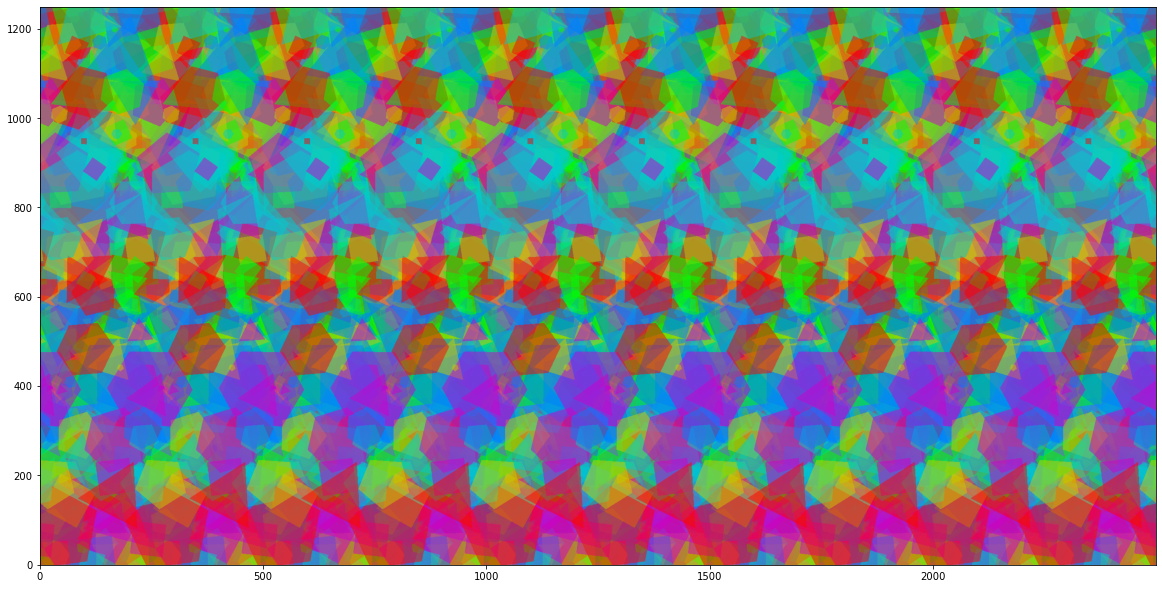

In [784]:
plt.figure(figsize=(20,20))
plt.imshow(imgArr, origin='lower')
plt.gca().set_aspect(1)

---

In [803]:
# -- Transforms a depth map to a pixel offset map --

# This is the key function for creating the autostereogram
# Here, I use a linear map of depth -> offset, which is "good enough" for simple autostereograms
# For a more realistic mapping, see: https://www2.cs.sfu.ca/CourseCentral/414/li/material/refs/SIRDS-Computer-94.pdf

def depth2YOffsetPix(depthArr, columnWidth):
    yOffsetArr = np.zeros([depthArr.shape[0], depthArr.shape[1]+columnWidth])
    yOffsetArr[:,:columnWidth//2] = 0
    yOffsetArr[:,-columnWidth//2:] = 0
    for row in range(yOffsetArr.shape[0]):
        for col in range(columnWidth//2, yOffsetArr.shape[1]-columnWidth//2):
            currDepth = depthArr[row, col-columnWidth//2]
            yOffsetArr[row, col] = yOffsetArr[row, col-columnWidth+int(currDepth)] + depthArr[row, col-columnWidth//2]
        yOffsetArr[row,:] -= np.mean(yOffsetArr[row,:])
    return yOffsetArr

In [804]:
# -- Remaps an array of color values to a new set of pixels --
# Again, there are definitely libraries for this that I was too lazy to learn to use

def imgValAtVectorized(imgArr, xArr, yArr, nColorbands=3):
    infs = 0.0001 # The code breaks if x or y exactly equals the max pixel, fml
    xMax, yMax = imgArr.shape[:2]
    x, y = np.clip(xArr, 0, xMax-1-infs), np.clip(yArr, 0, yMax-1-infs)
    
    # Drop a pixel-size square at x,y and average the colors that fall within it
    xLower, yLower = x.astype(int), y.astype(int)
    xUpper, yUpper = xLower, yLower
    xLowerFrac, yLowerFrac = x%1., y%1.
    xUpperFrac, yUpperFrac = 1-xLowerFrac, 1-yLowerFrac
    
    # Manually match the dimensions bc numpy is being a jerk about it
    if nColorbands > 1:
        xLowerFrac, yLowerFrac = np.dstack([xLowerFrac]*nColorbands), np.dstack([yLowerFrac]*nColorbands)
        xUpperFrac, yUpperFrac = np.dstack([xUpperFrac]*nColorbands), np.dstack([yUpperFrac]*nColorbands)
    
    return (
        imgArr[xLower, yLower] * xLowerFrac*yLowerFrac +
        imgArr[xLower, yUpper] * xLowerFrac*yUpperFrac +
        imgArr[xUpper, yLower] * xUpperFrac*yLowerFrac +
        imgArr[xUpper, yUpper] * xUpperFrac*yUpperFrac
    )

In [805]:
# -- Image transform code --
# Used for loading in the rocket image

from matplotlib import image

def resize(img, factor):
    xIndices, yIndices = np.indices(img.shape)
    newXSize, newYSize = int(img.shape[0]*factor), int(img.shape[1]*factor)
    newXIndices, newYIndices = np.indices((newXSize, newYSize)) / factor
    return imgValAtVectorized(img, newXIndices, newYIndices, nColorbands=1)

def rotate(img, theta):
    xIndices, yIndices = np.indices(img.shape)
    xCtr, yCtr = img.shape[0]//2, img.shape[1]//2
    xIndicesRot = (xIndices-xCtr)*np.cos(theta) - (yIndices-yCtr)*np.sin(theta)
    yIndicesRot = (yIndices-yCtr)*np.cos(theta) + (xIndices-xCtr)*np.sin(theta)
    xIndicesRot += xCtr
    yIndicesRot += yCtr
    return imgValAtVectorized(img, xIndicesRot, yIndicesRot, nColorbands=1)    

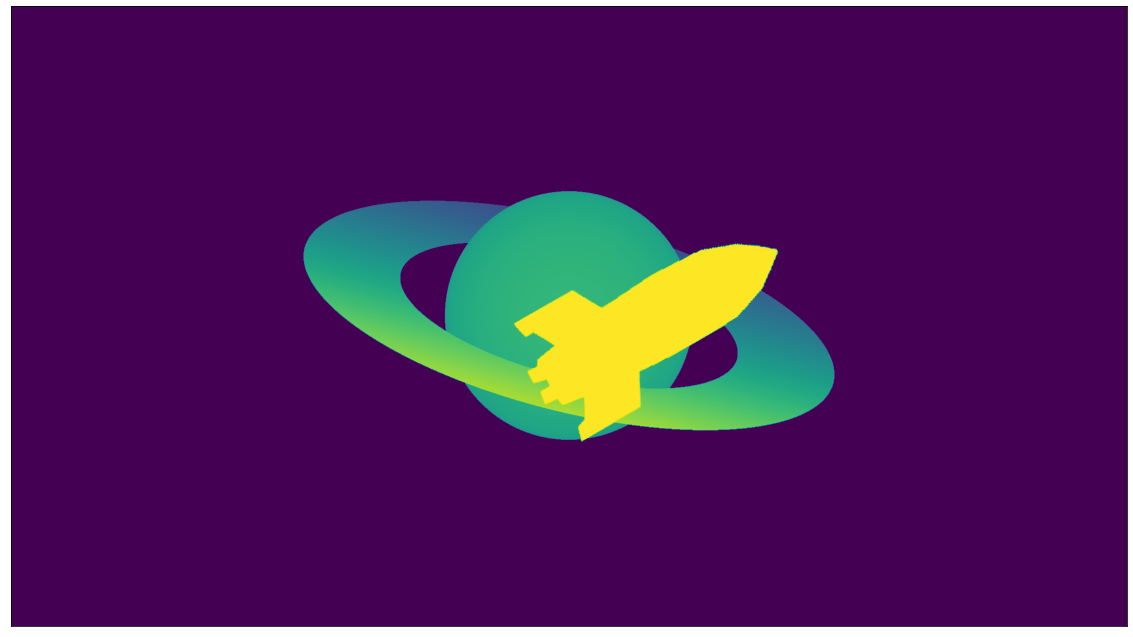

In [813]:
# -- Creates the depth map --

import warnings
warnings.filterwarnings('ignore')

depthArrMaster = np.zeros([imgArr.shape[0], imgArr.shape[1]-imgPixPerUnit])

columnWidth = imgPixPerUnit
xIndices, yIndices = np.indices(imgArr.shape[:2])
xIndices, yIndices = xIndices.astype(float), yIndices.astype(float)
xIndices = xIndices[:, columnWidth//2:-columnWidth//2]
yIndices = yIndices[:, columnWidth//2:-columnWidth//2]
xCtr, yCtr = np.median(xIndices), np.median(yIndices)
r = np.sqrt((xIndices-xCtr)**2 + (yIndices-yCtr)**2)

# Sphere
R = 250
depthArr = np.sqrt(R**2 - r**2) / R
depthArr[~np.isfinite(depthArr)] = 0
depthArr *= 20
depthArrMaster += depthArr

# (Boosts the height of the sphere)
condInDisk = r < R
depthArrMaster[condInDisk] += 30

# Ring
center = 30
ellipseCompressFactor = 0.35
ellipseAngle = -0.25
Rin = 350
Rout = 550
ellipseEffRadius = (xIndices)
xEff = (xIndices-xCtr)*np.cos(ellipseAngle) + (yIndices-yCtr)*np.sin(ellipseAngle)
yEff = (yIndices-yCtr)*np.cos(ellipseAngle) - (xIndices-xCtr)*np.sin(ellipseAngle)
rEff = np.sqrt((xEff/ellipseCompressFactor)**2 + (yEff)**2)
condInEllipse = (rEff > Rin) & (rEff < Rout)
condInEllipse &= ((xEff > 0) | ~condInDisk) # Occlusion by the sphere
ringDepthMap = 0.3*xEff + 30
depthArr = np.zeros(depthArrMaster.shape)
depthArr[condInEllipse] = ringDepthMap[condInEllipse]
depthArrMaster[condInEllipse] = depthArr[condInEllipse]

# Manually gives Saturn a "boost", then compresses its depth
depthArrMaster[(condInEllipse | condInDisk)] += 66
depthArrMaster[(condInEllipse | condInDisk)] /= 2.5

# Rocket
rocket = image.imread('rocket.png')[:,:,3]
rocket = rotate(resize(img,2), -np.pi/6)
rocketX, rocketY = 330, 1000
rocketXSize, rocketYSize = rocket.shape
condInRocket = (rocket != 0)
depthArrMaster[rocketX:rocketX+rocketXSize, rocketY:rocketY+rocketYSize][condInRocket] = rocket[condInRocket] * 10 + 60

# Plots the depth map
plt.figure(figsize=(20,20))
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.imshow(depthArrMaster)
plt.show()

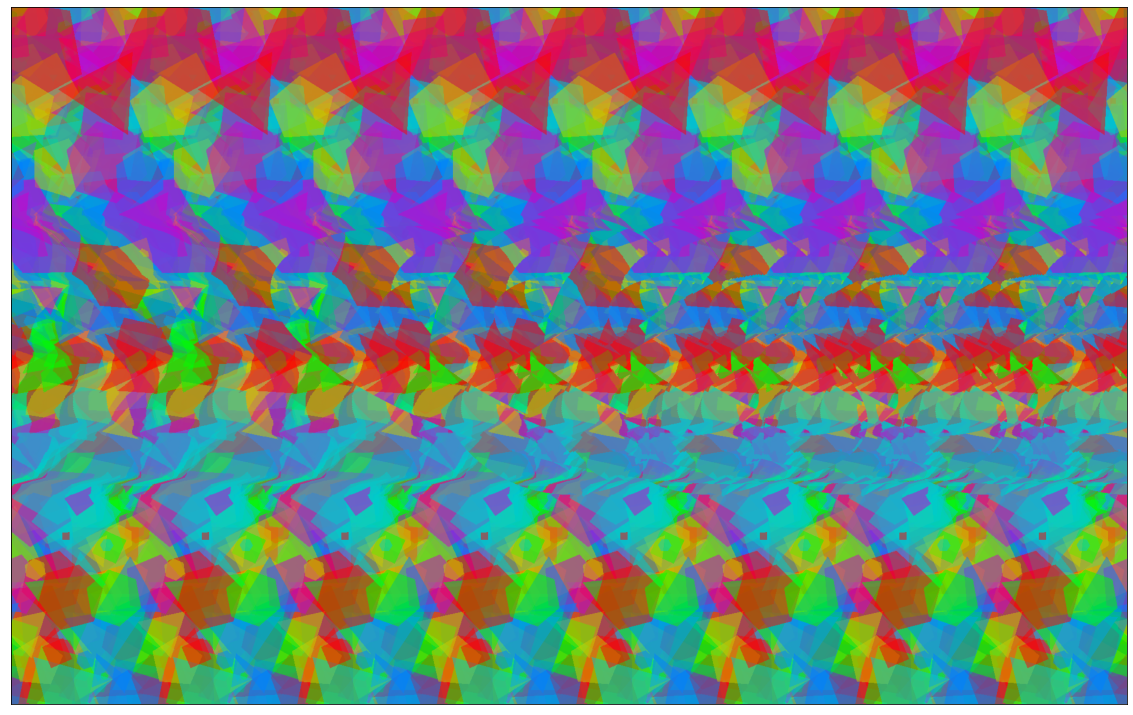

In [814]:
# -- Plots the autostereogram --

xIndices, yIndices = np.indices(imgArr.shape[:2])
yIndicesOffset = depth2YOffsetPix(depthArrMaster, columnWidth)

plt.figure(figsize=(20,20))
imgProcessed = imgValAtVectorized(imgArr, xIndices, yIndices + yIndicesOffset)[:,imgPixPerUnit:-imgPixPerUnit]
plt.imshow(imgProcessed)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.show()